# Bayesian hierachical model :
### probabilistic model that allows for modeling complex, multi-level data structures by specifying hierachy of model
###### the basic idea is that the data at each level of the hhierachy is modeled as being generated by a lower-level model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from collections import Counter
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
#generate some fake data

np.random.seed(123)
n_groups = 3
n_obs = 100
group_size = n_obs// n_groups

#Define the group -level params
α_true = np.array([-1, 0, 1])
β_true = np.array([0.5, -0,5, 1])
σ_true = np.array([0.5, 0.5, 0.5])

#generate the data
x = np.random.randn(n_obs)
y = np.random.randn(n_obs)
group = np.random.randint(0, n_groups, n_obs)

for i in range(n_groups):
    x_g = x[group == i]
    y_g = y[group == i]
    group_count = Counter(group)[i]
    x_g = np.repeat(x_g, group_count // x_g.shape[0])
    y_g = np.repeat(y_g, group_count // y_g.shape[0])
    y_g = α_true[i] + β_true[i] * x_g + σ_true[i] * np.random.randn(y_g.shape[0])
    


In [13]:
#define the model

with pm.Model() as Bhm:
    #define the hyperpriors
    μ_α = pm.Normal('μ_α', mu = 0, sd =10, testval =-1)
    σ_α = pm.HalfNormal('σ_α', sd = 10, testval =0.5)
    μ_β = pm.Normal('μ_β', mu=0, sd =10, testval=0.5)
    σ_β = pm.HalfNormal('σ_β', sd=10, testval=0.5)
    μ_σ = pm.Normal('μ_σ', mu =0, sd = 10,testval=0.5)
    σ_σ = pm.HalfNormal(' σ_σ', sd = 10, testval=0.5)
    #define the group-level priors
    α = pm.Normal('α', mu = μ_α, sd = σ_α, shape = n_groups)
    β = pm.Normal('β', mu = μ_β, sd = σ_β, shape = n_groups)
    σ = pm.HalfNormal('σ', sd = μ_σ , shape = n_groups)
    
    #define the likelihood
    y_obs = pm.Normal('y_obs', mu =α[group] + β[group] * x, sd = σ[group], observed =y)
    #perform MCMC sampling
    trace = pm.sample(2000, chains =2)

<ipython-input-13-1f8ef208c470>:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, chains =2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [σ, β, α,  σ_σ, μ_σ, σ_β, μ_β, σ_α, μ_α]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 27 seconds.
There were 300 divergences after tuning. Increase `target_accept` or reparameterize.
There were 464 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7122236602578691, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


to fix the divergences, try the following options:
* increace the target acceptance rate using `target_accept` argument in the `pm.sample()` function. A  higher targer acceptance rate make the proposal dist less restrictive, and therefore more likely to find good proposals.
* reparameterize the model: by changing the parametrization of the model, you can make the sampling more efficient by reducing the correlation between params, or making proposal dist better-matched to the target dist
* increase number of tuning steps using `tune` argument in the `pm.sample()` function. more tuning steps will give sample more time to adapt to the target distribution

This example defines a Bayesian hierarchical model with group-level parameters (α, β, σ) and hyper-parameters (μ_α, σ_α, μ_β, σ_β, μ_σ, σ_σ)
that describe the prior distribution of the group-level parameters.
The likelihood is defined as a normal distribution with mean equal to the linear combination of the predictors and the group-level parameters
and standard deviation equal to the group-level parameters

<ipython-input-16-dbeb5e446e2c>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


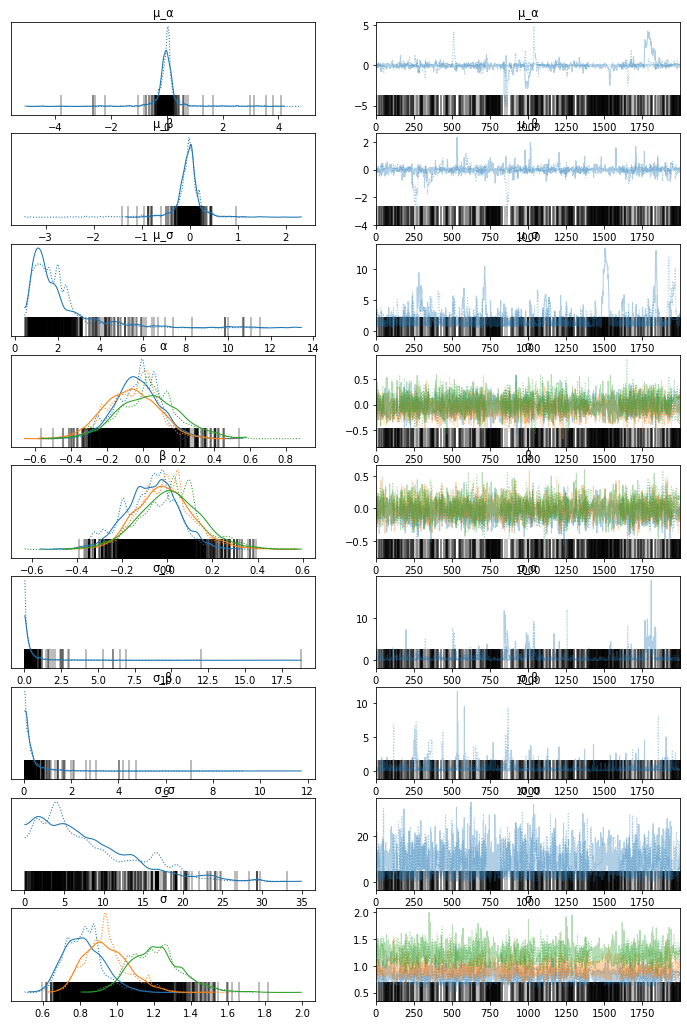

In [16]:
pm.traceplot(trace)
plt.show()

In [17]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_α,-0.004,0.639,-0.950,0.790,0.057,0.040,260.0,139.0,1.01
μ_β,-0.046,0.333,-0.533,0.527,0.023,0.016,405.0,205.0,1.01
μ_σ,2.075,1.653,0.457,4.915,0.131,0.097,275.0,178.0,1.00
α[0],-0.030,0.130,-0.278,0.209,0.005,0.004,605.0,447.0,1.00
α[1],-0.063,0.144,-0.339,0.189,0.006,0.004,591.0,2271.0,1.00
α[2],0.034,0.171,-0.302,0.349,0.006,0.004,745.0,516.0,1.00
β[0],-0.073,0.119,-0.304,0.145,0.007,0.005,338.0,155.0,1.01
β[1],-0.012,0.126,-0.263,0.220,0.004,0.003,1035.0,1032.0,1.01
β[2],0.015,0.143,-0.264,0.292,0.004,0.003,1360.0,1529.0,1.00
σ_α,0.527,1.049,0.023,1.807,0.074,0.052,95.0,97.0,1.01


nother useful tool for checking the convergence is the Gelman-Rubin statistic. The Gelman-Rubin statistic compares the variance of the chain means to the variance within the chain, and is used to check for lack of convergence. A value close to 1 indicates that the chains have converged

In [23]:
#dont forget to install this library
#!pip install arviz

In [28]:
az.rhat(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (α_dim_0: 3, β_dim_0: 3, σ_dim_0: 3)
Coordinates:
  * α_dim_0  (α_dim_0) int32 0 1 2
  * β_dim_0  (β_dim_0) int32 0 1 2
  * σ_dim_0  (σ_dim_0) int32 0 1 2
Data variables:
    μ_α      float64 1.009
    μ_β      float64 1.015
    μ_σ      float64 1.004
    α        (α_dim_0) float64 1.005 1.002 1.003
    β        (β_dim_0) float64 1.01 1.007 1.003
    σ_α      float64 1.013
    σ_β      float64 1.027
     σ_σ     float64 1.006
    σ        (σ_dim_0) float64 1.005 1.004 1.001

the above output returns as estimate of the potential scale reduction factor for each variable in the trace . values of R-hat close 1 indicate that chains have converged

<ipython-input-20-db7a53547537>:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  pm.autocorrplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ_α\n0'}>,
        <AxesSubplot:title={'center':'μ_α\n1'}>,
        <AxesSubplot:title={'center':'μ_β\n0'}>],
       [<AxesSubplot:title={'center':'μ_β\n1'}>,
        <AxesSubplot:title={'center':'μ_σ\n0'}>,
        <AxesSubplot:title={'center':'μ_σ\n1'}>],
       [<AxesSubplot:title={'center':'α\n0, 0'}>,
        <AxesSubplot:title={'center':'α\n0, 1'}>,
        <AxesSubplot:title={'center':'α\n0, 2'}>],
       [<AxesSubplot:title={'center':'α\n1, 0'}>,
        <AxesSubplot:title={'center':'α\n1, 1'}>,
        <AxesSubplot:title={'center':'α\n1, 2'}>],
       [<AxesSubplot:title={'center':'β\n0, 0'}>,
        <AxesSubplot:title={'center':'β\n0, 1'}>,
        <AxesSubplot:title={'center':'β\n0, 2'}>],
       [<AxesSubplot:title={'center':'β\n1, 0'}>,
        <AxesSubplot:title={'center':'β\n1, 1'}>,
        <AxesSubplot:title={'center':'β\n1, 2'}>],
       [<AxesSubplot:title={'center':'σ_α\n0'}>,
        <AxesSubplot:title={'center':'σ_α\n1'}>,
  

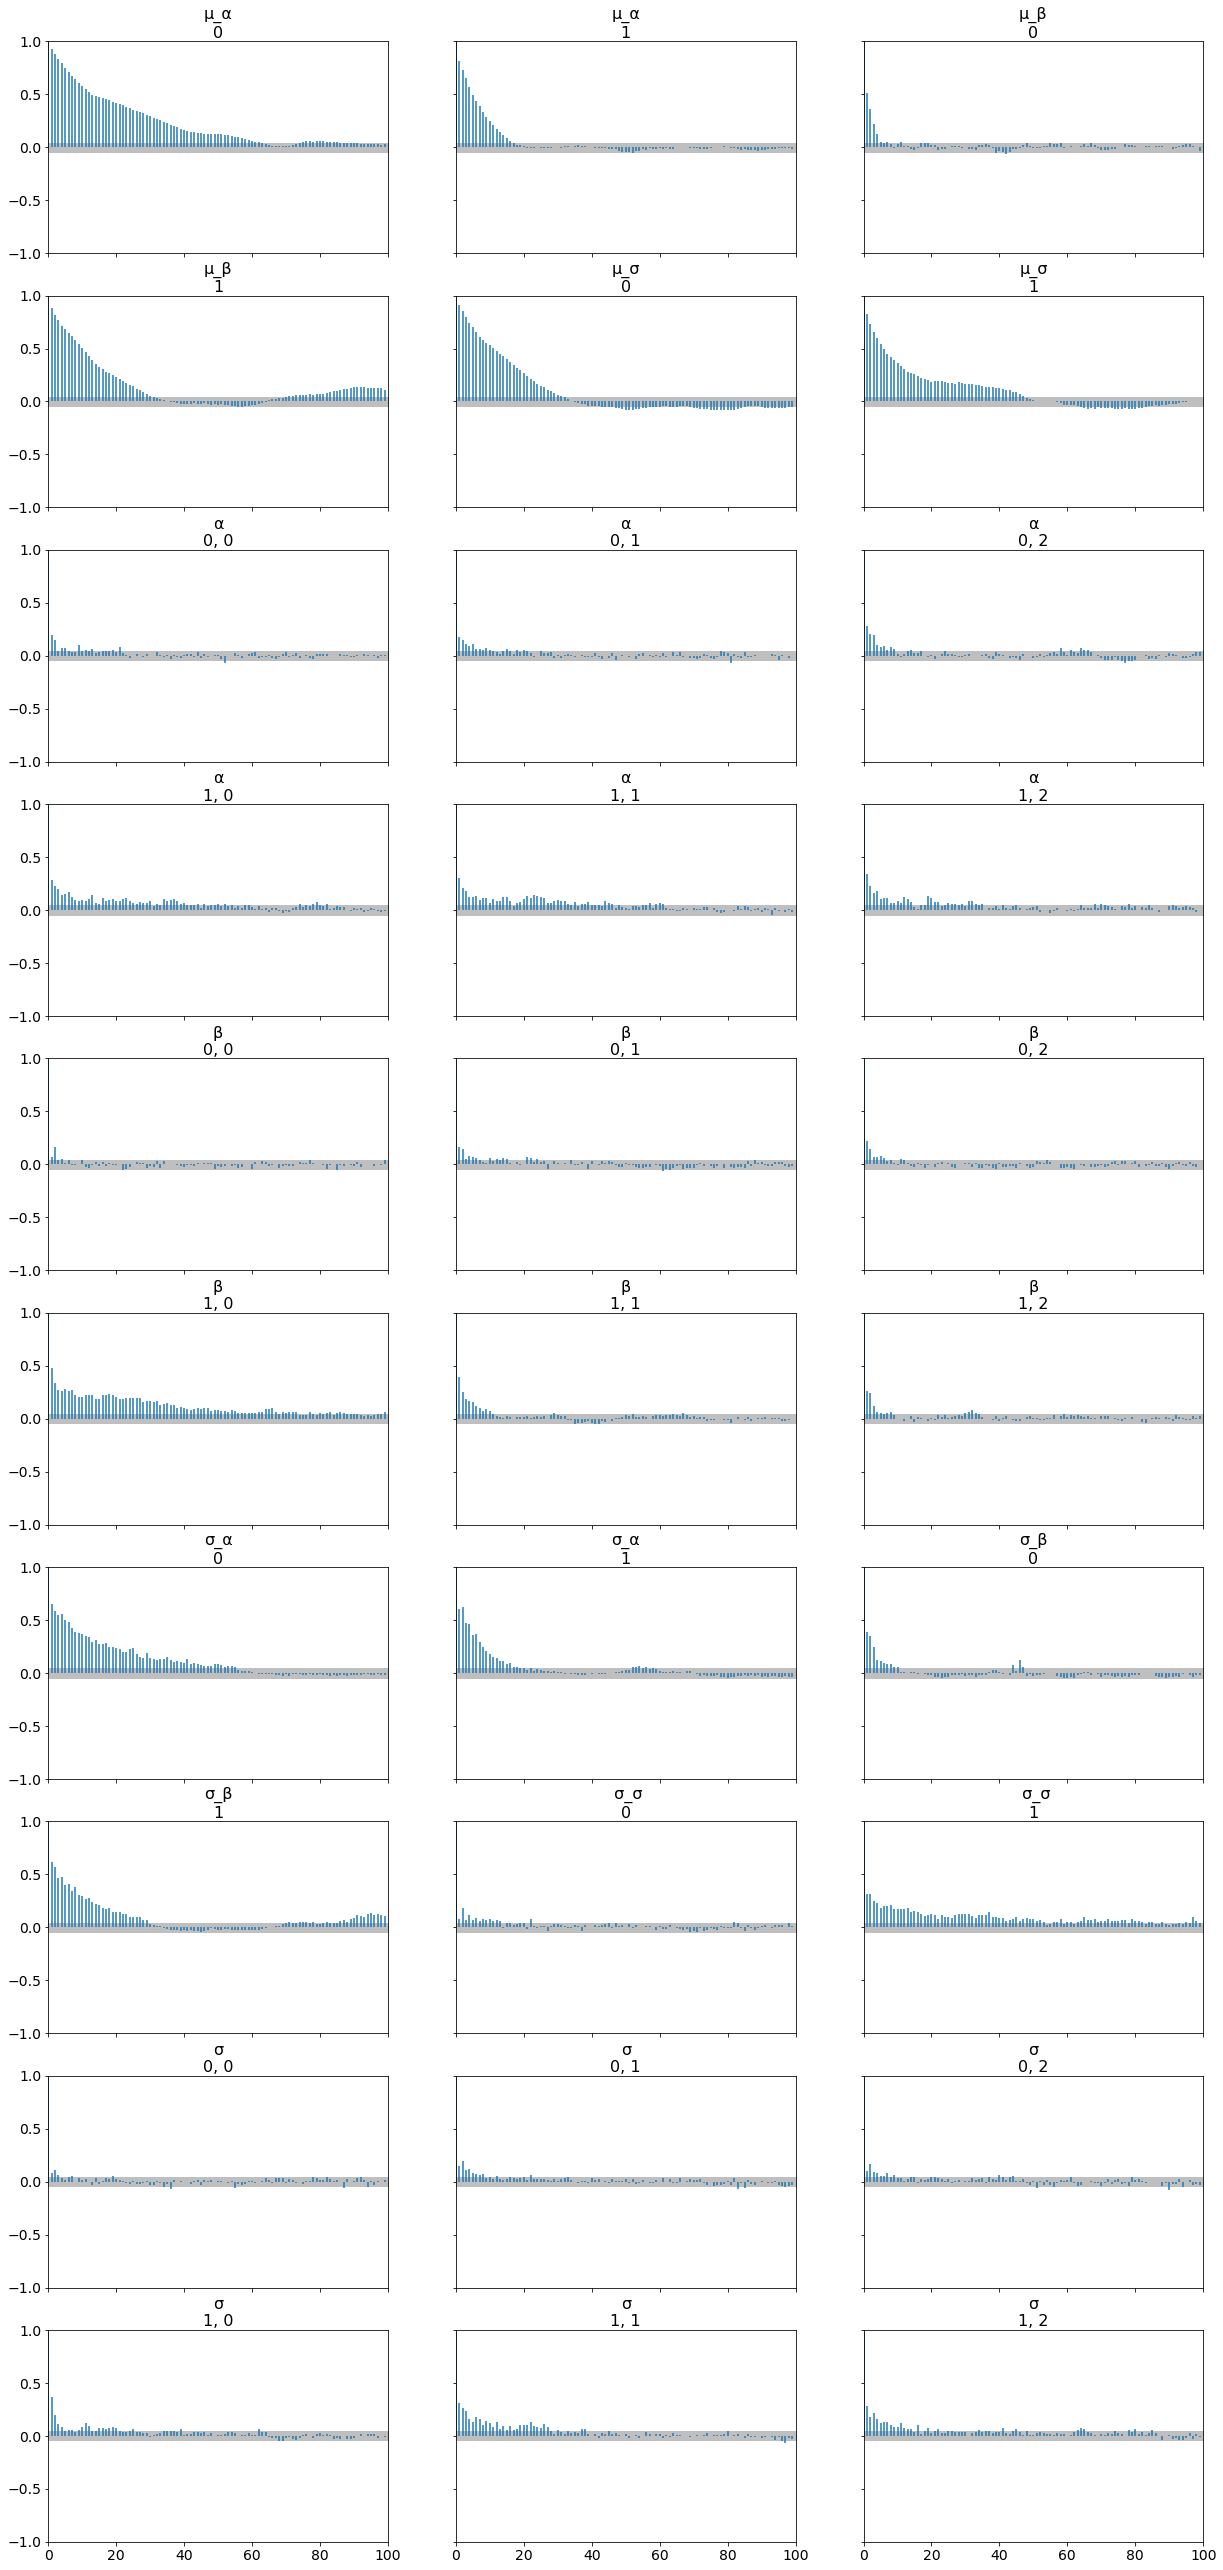

In [20]:
pm.autocorrplot(trace)

In [30]:
az.summary(trace, var_names=['α'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],-0.030,0.130,-0.278,0.209,0.005,0.004,605.0,447.0,1.0
α[1],-0.063,0.144,-0.339,0.189,0.006,0.004,591.0,2271.0,1.0
α[2],0.034,0.171,-0.302,0.349,0.006,0.004,745.0,516.0,1.0


In [31]:
az.summary(trace, var_names=['β'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],-0.073,0.119,-0.304,0.145,0.007,0.005,338.0,155.0,1.01
β[1],-0.012,0.126,-0.263,0.220,0.004,0.003,1035.0,1032.0,1.01
β[2],0.015,0.143,-0.264,0.292,0.004,0.003,1360.0,1529.0,1.00


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'α\n0'}>,
       <AxesSubplot:title={'center':'α\n1'}>,
       <AxesSubplot:title={'center':'α\n2'}>], dtype=object)

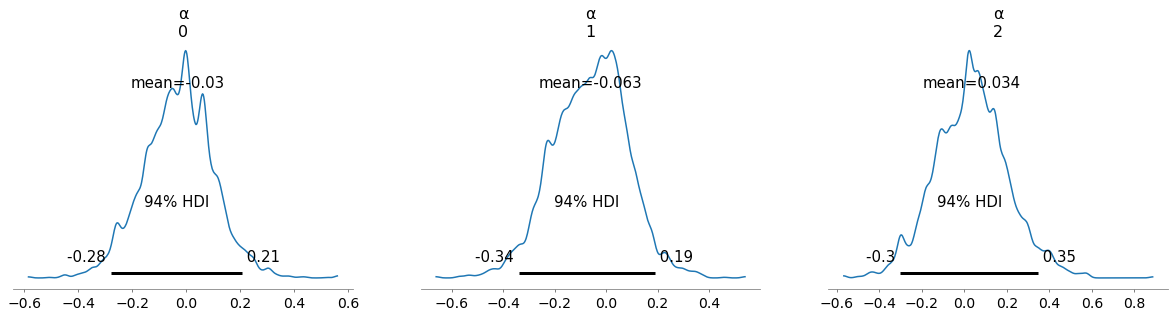

In [33]:
az.plot_posterior(trace, var_names=['α'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'β\n0'}>,
       <AxesSubplot:title={'center':'β\n1'}>,
       <AxesSubplot:title={'center':'β\n2'}>], dtype=object)

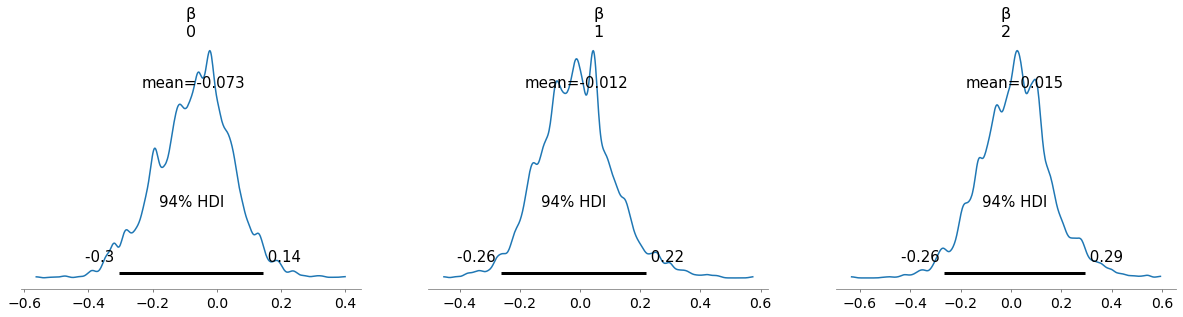

In [34]:
az.plot_posterior(trace, var_names=['β'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Mfund\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'α\n0'}>,
        <AxesSubplot:title={'center':'α\n1'}>,
        <AxesSubplot:title={'center':'α\n2'}>],
       [<AxesSubplot:title={'center':'β\n0'}>,
        <AxesSubplot:title={'center':'β\n1'}>,
        <AxesSubplot:title={'center':'β\n2'}>]], dtype=object)

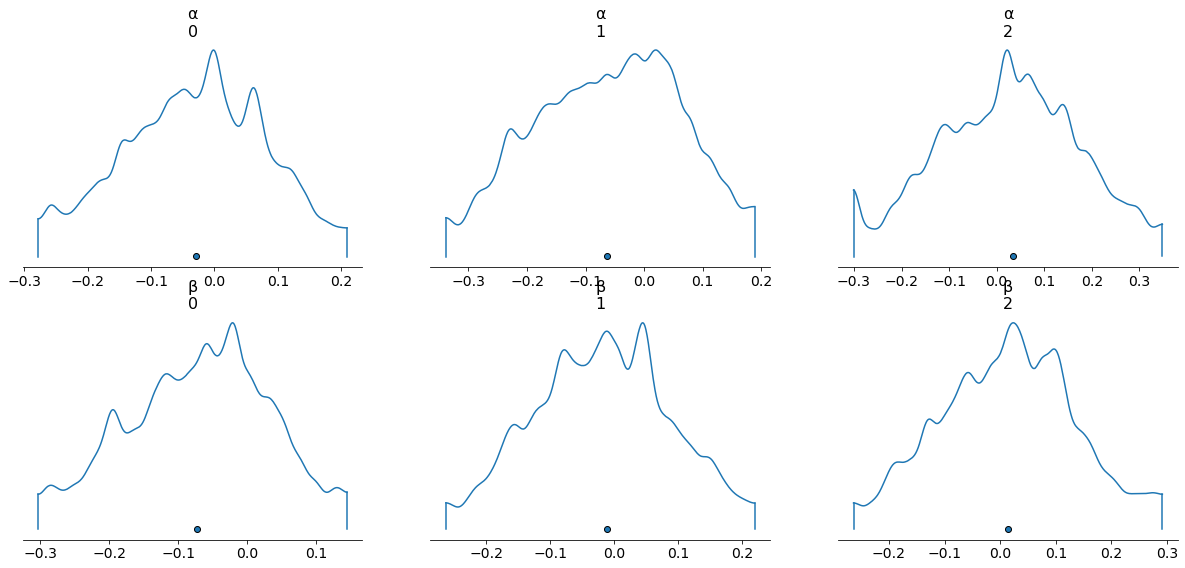

In [35]:
az.plot_density(trace, var_names=['α','β'])

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jan 21 2023

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.8.0

numpy     : 1.22.1
matplotlib: 3.6.3
pymc3     : 3.11.5
arviz     : 0.14.0

Watermark: 2.3.1

